# Develop an Image Search Engine for CIFAR-10 that takes the image as a query and retrieves top-5 similar images using Visual Bag of Words

## Importing the required libraries

In [2]:
# import the necessary packages
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC

## Download the CIFAR-10 dataset from the following link: https://www.cs.toronto.edu/~kriz/cifar.html and extract the dataset in the same folder as the code.

In [3]:
# download the CIFAR-10 dataset
if not os.path.exists('data/cifar-10-python.tar.gz'):
    !wget "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" -P "data"
    !tar -xvf "data/cifar-10-python.tar.gz" -C "data"

## Loadin the CIFAR-10 dataset


In [4]:
# load the CIFAR-10 dataset
train_data = []
test_data = []
# loading the training data
for i in range(1, 6):
    train_batch = np.load(f'data/cifar-10-batches-py/data_batch_{i}', allow_pickle=True, encoding='latin1')
    train_data.append(train_batch)
# loading the test data
test_batch = np.load('data/cifar-10-batches-py/test_batch', allow_pickle=True, encoding='latin1')

id_to_label = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [5]:
test_batch.keys()

dict_keys(['batch_label', 'labels', 'data', 'filenames'])

In [6]:
print(f"The training data has {len(train_data)} batches")
print(f"The training data has {len(train_data[0]['data'])} images")
print(f"The test data has {len(test_batch['data'])} images")

The training data has 5 batches
The training data has 10000 images
The test data has 10000 images


In [7]:
# convert the data into numpy arrays
train_data_img = []
train_labels = []
for batch in train_data:
    train_data_img.extend(np.array(batch['data']))
    train_labels.extend(np.array(batch['labels']))

print(f"length of train_data: {len(train_data_img)}")
print(f"length of train_labels: {len(train_labels)}")

length of train_data: 50000
length of train_labels: 50000


In [8]:
train_data_img = np.array(train_data_img)
train_data_labels = np.array(train_labels)
print(f"train_data_img shape: {train_data_img.shape}")
print(f"train_data_labels shape: {train_data_labels.shape}")

train_data_img shape: (50000, 3072)
train_data_labels shape: (50000,)


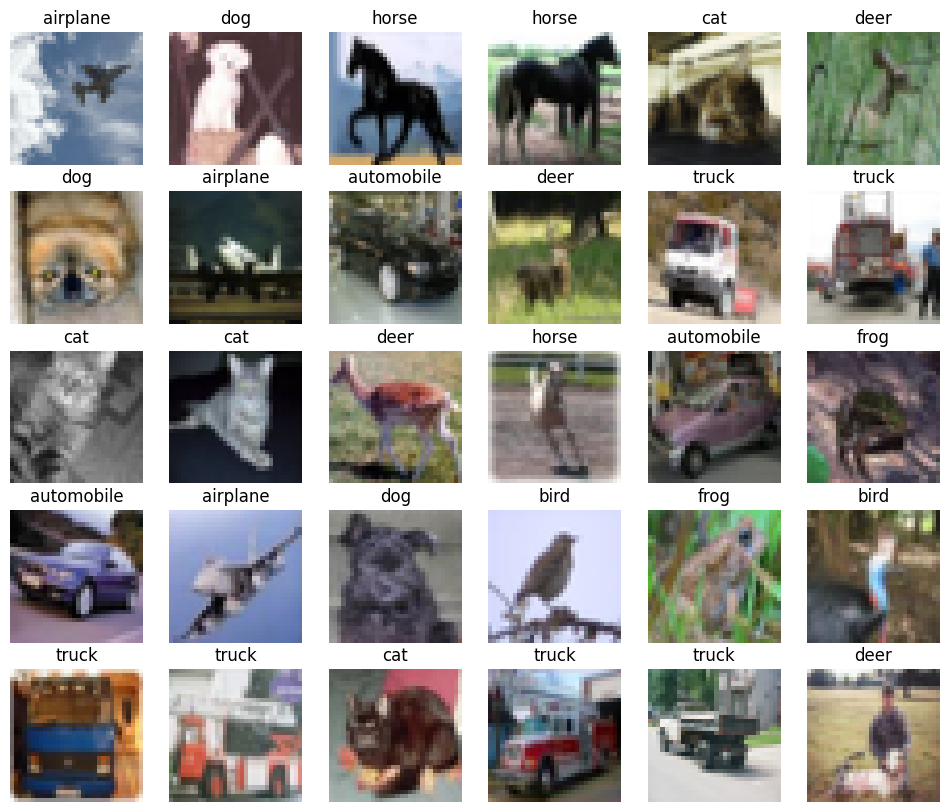

In [9]:
# plotting random 30 images from the training data
plt.figure(figsize=(12, 10))
img_index = np.random.randint(0, len(train_data_img), 30)
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.title(id_to_label[train_data_labels[img_index[i]]])
    plt.imshow(train_data_img[img_index[i]].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.axis('off')

## Feature Extraction

In [10]:
# function to extract SIFT features from the images
sift = cv.SIFT_create()

descriptor_list = []
for img in train_data_img:
    img = img.reshape(3, 32, 32).transpose(1, 2, 0)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    descriptor_list.append(des)

In [11]:
# remove the None values from the descriptor list
for i in range(len(descriptor_list)):
    if descriptor_list[i] is None:
        descriptor_list[i] = np.zeros((1, 128))

In [12]:
# Create visual vocabulary using K-Means clustering
descriptors = np.concatenate(descriptor_list, axis=0)
print(f"shape of descriptors: {descriptors.shape}")
kmeans = KMeans(n_clusters=100, random_state=0,n_init="auto").fit(descriptors)

shape of descriptors: (650433, 128)


In [13]:
# create histograms for each image
histograms = []
for des in descriptor_list:
    histogram = np.zeros(100)
    for i in range(len(des)):
        index = kmeans.predict([des[i]])
        histogram[index] += 1
    histograms.append(histogram)


In [14]:
# Train a linear SVM classifier
X_train = np.array(histograms)
y_train = np.array(train_data_labels)
print(f"shape of X_train: {X_train.shape}")
print(f"shape of y_train: {y_train.shape}")
clf = SVC(kernel='linear', C=1.0).fit(X_train, y_train)
clf

shape of X_train: (50000, 100)
shape of y_train: (50000,)


SVC(kernel='linear')

In [70]:
# perform the same steps for the test data
y = test_batch['labels']
y_pred = []
for i in range(len(test_batch['data'])):
    data = np.array(test_batch['data'][i]).reshape(3, 32, 32).transpose(1, 2, 0)
    kp, des = sift.detectAndCompute(data, None)
    # padding the descriptors with zeros if the length is less than 128
    if des is None:
        des = np.zeros((1, 128))
    des = np.pad(des, ((0, 128-len(des)), (0, 0)), 'constant')
    index = kmeans.predict(np.array(des,dtype=np.float64))
    hist, _ = np.histogram(index, bins=100)
    y_hat = clf.predict([hist])
    y_pred.append(y_hat[0])

In [71]:
# calculate the accuracy, precision, recall and f1-score, AP
accuracy = np.sum(np.array(y_pred) == np.array(y)) / len(y)
precision = np.sum(np.array(y_pred) == np.array(y)) / np.sum(np.array(y_pred) == 1)
recall = np.sum(np.array(y_pred) == np.array(y)) / np.sum(np.array(y) == 1)
f1_score = 2 * (precision * recall) / (precision + recall)
AP = np.sum(np.array(y_pred) == np.array(y)) / len(y)

print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")
print(f"AP: {AP}")

accuracy: 0.1016
precision: 0.7773527161438408
recall: 1.016
f1_score: 0.8807975726051149
AP: 0.1016


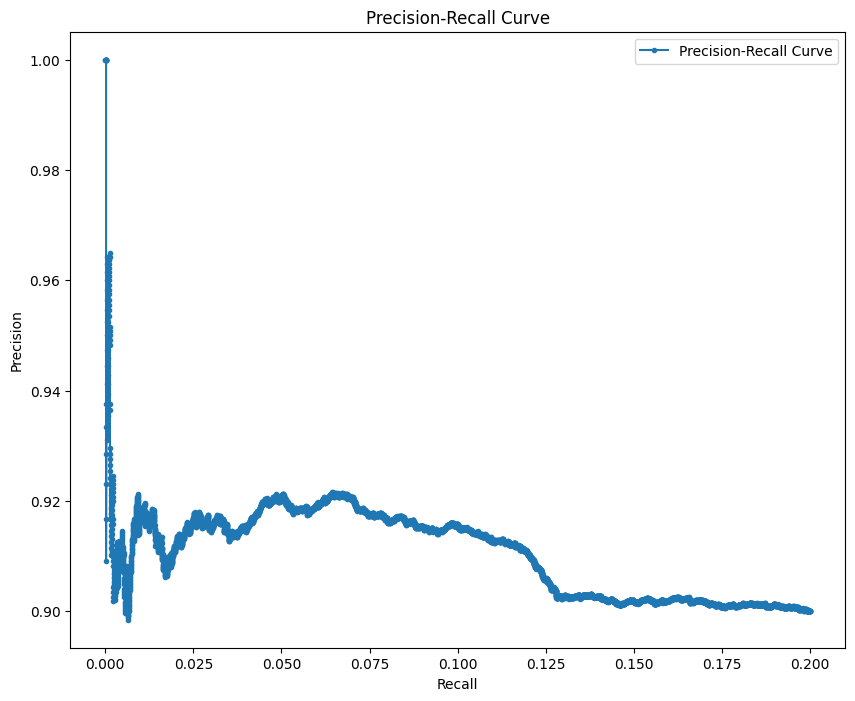

In [72]:
import numpy as np

def precision_recall_curve(y_true, y_pred):
    # Sort predicted scores and true labels in descending order of scores
    order = np.argsort(y_pred)[::-1]
    y_true = np.asarray(y_true)[order]
    y_pred = np.asarray(y_pred)[order]

    # Initialize variables for true positives (TP), false positives (FP), and false negatives (FN)
    TP = 0
    FP = 0
    FN = np.sum(y_true)

    # Initialize arrays for precision, recall, and threshold values
    precisions = np.zeros_like(y_true, dtype=float)
    recalls = np.zeros_like(y_true, dtype=float)
    thresholds = np.zeros_like(y_true, dtype=float)

    # Compute precision, recall, and threshold values for each predicted score
    for i in range(len(y_pred)):
        if y_true[i]:
            TP += 1
            FN -= 1
        else:
            FP += 1
        precisions[i] = TP / (TP + FP)
        recalls[i] = TP / (TP + FN)
        thresholds[i] = y_pred[i]

    return precisions, recalls, thresholds

precision, recall, th = precision_recall_curve(y, y_pred)
# Draw Precision-Recall Curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Testing the model

In [395]:
# query image
index = 4275
index = 6069
index = 6503

test_img,test_img_label = test_batch['data'][index], test_batch['labels'][index]
print(test_img.shape, test_img_label)

(3072,) 6


In [396]:
# detect SIFT features
kp, des = sift.detectAndCompute(test_img.reshape(3, 32, 32).transpose(1, 2, 0), None)
index = kmeans.predict(np.array(des,dtype=np.float64))

# make histogram for the query image
query_histogram, _ = np.histogram(index, bins=100, range=(0, 100))

# predict the class of the query image
y_pred = clf.predict([query_histogram])
print(f"Predicted class: {id_to_label[y_pred[0]]}")
print(f"Actual class: {id_to_label[test_img_label]}")

Predicted class: frog
Actual class: frog


In [397]:
# retrieve the images from the training data that are similar to the query image
idx = np.where(y_train == y_pred[0])[0]
hist = np.array(histograms)[idx]

In [398]:
# Calculate the distance between the query image and the images in the training data
distances = []
for i in range(len(hist)):
    distances.append(np.linalg.norm(hist[i] - query_histogram))

sorted_idx = np.argsort(distances)
top_5_idx = sorted_idx[:5]

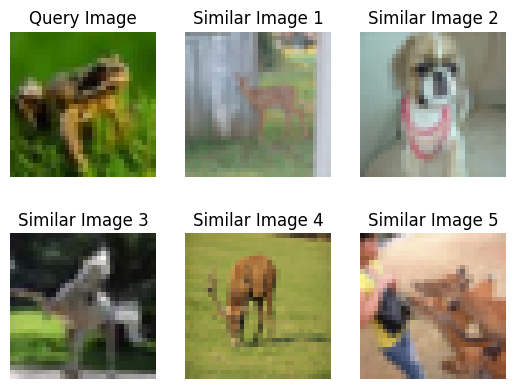

In [399]:
# plot the query image and the top 5 similar images
for i in range(6):
    plt.subplot(2, 3, i+1)
    if i == 0:
        plt.imshow(test_img.reshape(3, 32, 32).transpose(1, 2, 0))
        plt.title("Query Image")
    else:
        plt.imshow(train_data_img[top_5_idx[i-1]].reshape(3, 32, 32).transpose(1, 2, 0))
        plt.title(f"Similar Image {i}")
    plt.axis('off')